# Getting the data

Using an open repositoriy

In [1]:
import os
import tarfile
from six.moves import urllib
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

# Loading and Seeing the Data

In [2]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [3]:
housing = load_housing_data()
housing.head()
# housing.info()
# housing["ocean_proximity"].value_counts()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [6]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

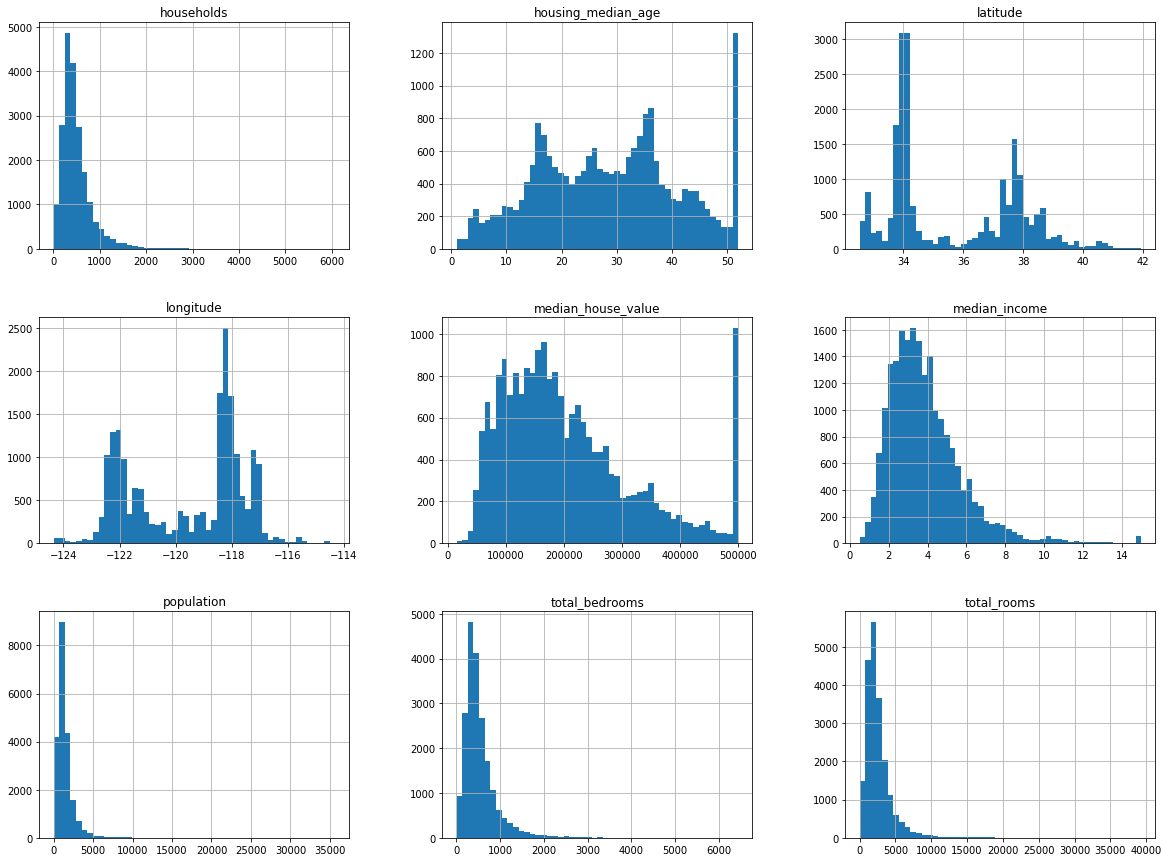

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

### Notes:
* Median income was scaled and cappted at 15 and 0.5
* Median income is in 10s of thousands USD
* Housing median age and median house value were capped. The latter is a problem because it is the target parameter...
    * get propper labels from the capped districts
    * remove capped districts from the dataset
* Attributes have different scale -> normalise
* Histograms are tail heavy

# Splitting in Train and Test Set

In [8]:
import numpy as np
def split_train_test(data, test_ratio):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), len(test_set))

16512 4128


In [9]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]


housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")   # adds an `index` column

housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [11]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, 
                                       test_size=0.2, 
                                       random_state=42)

# Analyzing the Data

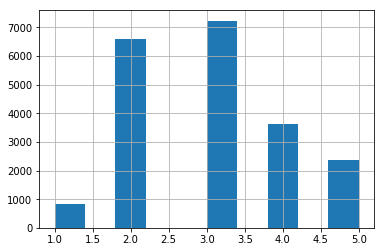

In [12]:
housing["income_cat"] = pd.cut( housing["median_income"],
                                bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                                labels=[1, 2, 3, 4, 5] )
housing["income_cat"].hist()

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

strat_test_set["income_cat"].value_counts() / len(strat_test_set)


3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [14]:
# remove income_cat from the data
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)


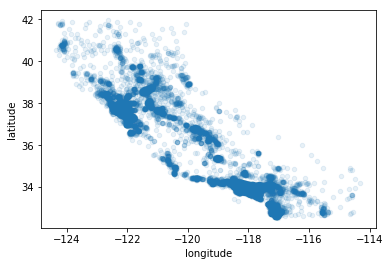

In [15]:
housing = strat_train_set.copy()
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

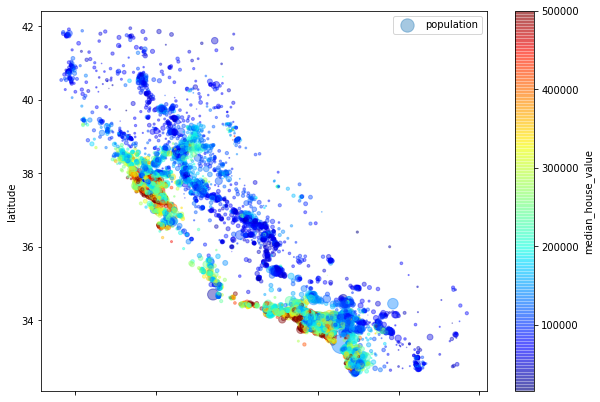

In [16]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, 
             label="population", 
             figsize=(10,7),
             c="median_house_value", 
             cmap=plt.get_cmap("jet"), 
             colorbar=True)
plt.legend()


In [17]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)
# +1 -> strong positive correlation
# -1 -> strong negative correlation
#  0 -> no correlation

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B70B5B8DA0>,
      dtype=object)

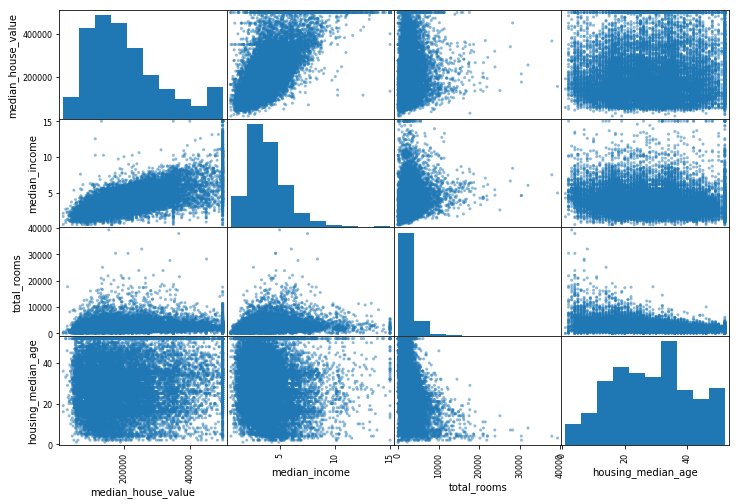

In [18]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", 
              "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))


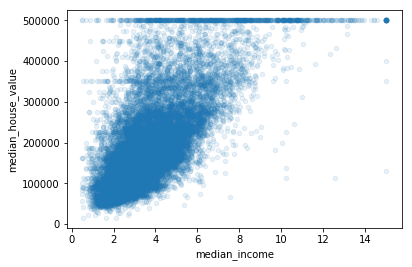

In [19]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", 
             alpha=0.1)

In [20]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [21]:
# Revert to the clean training set
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

# Data Cleaning

total_bedrooms has missing values, 3 options to fix:
* Get rid of the corresponding districts.
* Get rid of the whole attribute.
* Set the values to some value (zero, the mean, the median, etc.).

```python
housing.dropna(subset=["total_bedrooms"])    # option 1
housing.drop("total_bedrooms", axis=1)       # option 2
median = housing["total_bedrooms"].median()  # option 3
housing["total_bedrooms"].fillna(median, inplace=True)
```

In [22]:
# sk has its own way
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

# cant compute text's median
housing_num = housing.drop("ocean_proximity", axis=1)

# fit to training data
imputer.fit(housing_num)

# use imputer to replace missing values by learned medians
X = imputer.transform(housing_num)

# Handling text and Categorical Attributes

basically convert it to numbers
* Ordinal encoder
* One-hot encoder
* Custom

In [23]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

ocean_proximity
17606       <1H OCEAN
18632       <1H OCEAN
14650      NEAR OCEAN
3230           INLAND
3555        <1H OCEAN
19480          INLAND
8879        <1H OCEAN
13685          INLAND
4937        <1H OCEAN
4861        <1H OCEAN

In [24]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10].T
# cats in - ordinal_encoder.categories_

array([[0., 0., 4., 1., 0., 1., 0., 1., 0., 0.]])

In [25]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot.toarray()
# cats in -  cat_encoder.categories_

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [26]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

# Feature Scaling
* Min-max scaler - MinMaxScaler()
* standardization - StandardScaler()

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), # data cleaning
    ('attribs_adder', CombinedAttributesAdder()),  # adds the combined attributes
    ('std_scaler', StandardScaler()),              # feature scaling
])

housing_num_tr = num_pipeline.fit_transform(housing_num)


In [28]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])
housing_prepared = full_pipeline.fit_transform(housing)


# Train a model

* Linear Regressor
* Decision Tree Regressor
* Random Forest

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)

print(lin_rmse)

68628.19819848923


In [30]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)

print(tree_rmse)

0.0


In [31]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)

print(forest_rmse)

c:\users\ricardo\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


22493.361555650783


# Cross Validation

Scikit-Learn’s K-fold cross-validation feature.
* Randomly splits the training set into 10 distinct subsets called folds 
* Trains and evaluates the Decision Tree model 10 times, picking a different fold for evaluation every time and training on the other 9 folds.
* The result is an array containing the 10 evaluation scores


In [32]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [33]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

display_scores(tree_rmse_scores)

Scores: [67669.73816437 67362.61970456 70229.34328631 68299.62160307
 71291.36213287 75577.59634532 72668.53981039 70226.23940832
 77010.86953522 69438.29976359]
Mean: 70977.42297540254
Standard deviation: 3085.3445235048844


In [34]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.6740017983425


In [35]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

Scores: [52868.21871547 49194.92340594 51713.77716246 55012.10310441
 50973.88861214 55990.4479905  52298.68285092 50953.09058463
 54428.48087563 53461.73225682]
Mean: 52689.53455589254
Standard deviation: 1980.36257012708


### Observations

* Scores on the training set are much lower, so model is likely overfitting
* Solutins:
    * Simplify model
    * regularization
    * more data

# Saving the model

It is easy to save model, inc hyperparameters
* joblib
* pickle

```python
from sklearn.externals import joblib

joblib.dump(my_model, "my_model.pkl")
# and later...
my_model_loaded = joblib.load("my_model.pkl")

```

# Model Tuning

* Grid Search
* Randomized Search
    * tries hyperparemeters at random
* Ensemble Methods

In [36]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators': [3, 10, 30], 
     'max_features': [2, 4, 6, 8]
    },
    {'bootstrap': [False], 
     'n_estimators': [3, 10], 
     'max_features': [2, 3, 4]
    },
]
# Will explore 3*4 + 2*3 = 18 combinations of features

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', 
                           return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

grid_search.best_params_
# grid_search.best_estimator_

{'max_features': 6, 'n_estimators': 30}

### Analyze best models

In [37]:
feature_importances = grid_search.best_estimator_.feature_importances_

extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])

attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.32754893001195934, 'median_income'),
 (0.13835019350471953, 'INLAND'),
 (0.10531956070724346, 'pop_per_hhold'),
 (0.09139658055040592, 'bedrooms_per_room'),
 (0.07696877663966344, 'longitude'),
 (0.07043198869339834, 'latitude'),
 (0.05577360056115168, 'rooms_per_hhold'),
 (0.04386606192454317, 'housing_median_age'),
 (0.018063044805051474, 'total_rooms'),
 (0.01794828495917463, 'population'),
 (0.016650874220719983, 'total_bedrooms'),
 (0.01599429894210943, 'households'),
 (0.01166380333543238, '<1H OCEAN'),
 (0.006080623745976417, 'NEAR OCEAN'),
 (0.003839400952575296, 'NEAR BAY'),
 (0.0001039764458754885, 'ISLAND')]

# Evaluating with Test Set

In [38]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse) # => evaluates to 47,730.2


In [39]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2

np.sqrt(stats.t.interval(confidence, 
                         len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))


array([45609.99728845, 49471.00339689])

## Using SVM

In [40]:
from sklearn.svm import SVR

param_grid = [
    { 'kernel': ['linear'], 'C': [0.1, 10] },
    { 'kernel': ['rbf'], 'C': [0.1, 1], 'gamma': [0.1, 3] },
]


svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', 
                           return_train_score=True, verbose=2)

grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] C=0.1, kernel=linear ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................. C=0.1, kernel=linear, total=   5.8s
[CV] C=0.1, kernel=linear ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.9s remaining:    0.0s


[CV] ............................. C=0.1, kernel=linear, total=   5.8s
[CV] C=0.1, kernel=linear ............................................
[CV] ............................. C=0.1, kernel=linear, total=   5.6s
[CV] C=0.1, kernel=linear ............................................
[CV] ............................. C=0.1, kernel=linear, total=   5.5s
[CV] C=0.1, kernel=linear ............................................
[CV] ............................. C=0.1, kernel=linear, total=   5.6s
[CV] C=10, kernel=linear .............................................
[CV] .............................. C=10, kernel=linear, total=   5.4s
[CV] C=10, kernel=linear .............................................
[CV] .............................. C=10, kernel=linear, total=   6.0s
[CV] C=10, kernel=linear .............................................
[CV] .............................. C=10, kernel=linear, total=   5.8s
[CV] C=10, kernel=linear .............................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  7.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [0.1, 10], 'kernel': ['linear']},
                         {'C': [0.1, 1], 'gamma': [0.1, 3], 'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=2)

In [41]:
svm_model = grid_search.best_estimator_
rmse = np.sqrt(-grid_search.best_score_)

print('params', grid_search.best_params_)
print('rmse', rmse)

params {'C': 10, 'kernel': 'linear'}
rmse 84654.0893002138


### Using Randomized Search

In [42]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, expon

# must be a dict, not a list
param_rand ={
    'kernel': ['linear', 'rbf'],
    'C': reciprocal(20, 200000),
    'gamma': expon(scale=1.0),}

svm_reg = SVR()

rand_search = RandomizedSearchCV(svm_reg, param_distributions=param_rand,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, random_state=42)

rand_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   6.2s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s remaining:    0.0s


[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   6.8s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   6.3s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   6.4s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   6.5s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  13.8s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  14.2s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  14.1s
[CV] C=26290.2

[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  56.3s
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  42.0s
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  53.7s
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  43.6s
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  37.2s
[CV] C=5385.293820172355, gamma=0.18696125197741642, kernel=linear ...
[CV]  C=5385.293820172355, gamma=0.18696125197741642, kernel=linear, total=   6.8s
[CV] C=5385.293820172355, gamma=0.18696125197741642, kernel=linear ...
[CV]  C=5385.293820172355, gamma=0.18696125197741642, kernel=linear, total=   7.1

[CV]  C=761.4316758498783, gamma=2.6126336514161914, kernel=linear, total=   5.2s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  28.2s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  28.0s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  51.1s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  28.9s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  23.6s
[CV] C=2423.0759984939164, gamma=3.248614270240346, kernel=linear ....
[CV]  C=2423.0759984939164, gamma=3.248614270240346, kernel=linear, total=   

[CV]  C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf, total=  22.3s
[CV] C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf .......
[CV]  C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf, total=  20.3s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=   9.2s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=   9.3s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=   9.2s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=   9.1s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=   9.2s
[CV] C=399.7268155705

[CV]  C=129.8000604143307, gamma=2.8621383676481322, kernel=linear, total=   5.3s
[CV] C=129.8000604143307, gamma=2.8621383676481322, kernel=linear ....
[CV]  C=129.8000604143307, gamma=2.8621383676481322, kernel=linear, total=   5.3s
[CV] C=129.8000604143307, gamma=2.8621383676481322, kernel=linear ....
[CV]  C=129.8000604143307, gamma=2.8621383676481322, kernel=linear, total=   5.2s
[CV] C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf ......
[CV]  C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf, total=   9.3s
[CV] C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf ......
[CV]  C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf, total=   9.4s
[CV] C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf ......
[CV]  C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf, total=   9.7s
[CV] C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf ......
[CV]  C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf, total=   9.9s
[CV] C=2

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 60.6min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, shrinking=True,
                                 tol=0.001, verbose=False),
                   iid='warn', n_iter=50, n_jobs=None,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B725417C88>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B725417978>,
                                        'kernel': ['linear', 'rbf']},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring='neg_mean_squared_error',
                   verbose=2)

# filter parameters

In [47]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

In [48]:
# Test functions above
k = 5
top_k_feature_indices = indices_of_top_k(feature_importances, k)
np.array(attributes)[top_k_feature_indices]

array(['longitude', 'median_income', 'pop_per_hhold', 'bedrooms_per_room',
       'INLAND'], dtype='<U18')

In [51]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

# these have to be equal
print(housing_prepared_top_k_features[0:3])
print(housing_prepared[0:3, top_k_feature_indices])

[[-1.15604281 -0.61493744 -0.08649871  0.15531753  0.        ]
 [-1.17602483  1.33645936 -0.03353391 -0.83628902  0.        ]
 [ 1.18684903 -0.5320456  -0.09240499  0.4222004   0.        ]]
[[-1.15604281 -0.61493744 -0.08649871  0.15531753  0.        ]
 [-1.17602483  1.33645936 -0.03353391 -0.83628902  0.        ]
 [ 1.18684903 -0.5320456  -0.09240499  0.4222004   0.        ]]


# Pipeline for data preparation and prediction

In [54]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rand_search.best_params_))
])

prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(memory=None,
         steps=[('preparation',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                              

In [55]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [185384.13066634 341000.56131537 172531.39955817  56040.55006167]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0]


# Automatic explore preparations

In [56]:
param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2)
grid_search_prep.fit(housing, housing_labels)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   6.8s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.7s remaining:    0.0s


[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   6.9s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   6.8s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   6.8s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   6.7s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=median, total=   6.8s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=median, total=   6.7s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__

[CV]  feature_selection__k=4, preparation__num__imputer__strategy=median, total=   7.3s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=median, total=   7.3s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=median, total=   7.4s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=most_frequent, total=   7.3s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=most_frequent, total=   7.4s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=4, preparation__num__imputer__strategy=most_frequent, total=   7.2s
[CV] feature_selection__k=4, preparation__num__imputer__strategy=

[CV]  feature_selection__k=7, preparation__num__imputer__strategy=most_frequent, total=   9.3s
[CV] feature_selection__k=7, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=7, preparation__num__imputer__strategy=most_frequent, total=   8.8s
[CV] feature_selection__k=7, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=7, preparation__num__imputer__strategy=most_frequent, total=   9.6s
[CV] feature_selection__k=8, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=8, preparation__num__imputer__strategy=mean, total=  10.6s
[CV] feature_selection__k=8, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=8, preparation__num__imputer__strategy=mean, total=  10.1s
[CV] feature_selection__k=8, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=8, preparation__num__imputer__strategy=mean, total=  11.5s
[CV] feature_selection__k=8, preparation__num__imputer__strategy=mean 
[CV]  feature

[CV]  feature_selection__k=11, preparation__num__imputer__strategy=mean, total=  20.6s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=mean, total=  18.8s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=mean, total=  21.6s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=median, total=  18.1s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=median, total=  21.5s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=median, total=  18.4s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=11, p

[CV]  feature_selection__k=14, preparation__num__imputer__strategy=median, total=  26.5s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=median, total=  26.9s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=median, total=  24.2s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=most_frequent, total=  26.8s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=most_frequent, total=  23.4s
[CV] feature_selection__k=14, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=14, preparation__num__imputer__strategy=most_frequent, total=  24.7s
[CV] feature_selection__k=14, preparation__num__impute

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 60.3min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preparation',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                     